In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [2]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "GbnXJ5bU3m9JPau", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('visapy_data.npy', 'wb') as out_file:
    data = response.read()
    out_file.write(data)

# raw data location
data_path = 'visapy_data.npy'

In [3]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 12
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [4]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


In [5]:
H.DetectFromRaw()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

In [6]:
# z = np.load(data_path)
# print(z.shape)

In [7]:
H.LoadDetected()

Detected and read 48009 spikes.


In [8]:
print(H.spikes['Shape'])

0        [18, 20, 16, 18, 15, 11, 17, 20, 9, -1, -6, -1...
1        [-7, -2, 4, -3, -8, 0, -8, -19, -7, -9, -40, -...
2        [-3, 6, 7, 1, 4, 8, 5, 9, 16, 8, -4, -4, -13, ...
3        [-6, 0, 0, 0, -8, -22, -19, -4, -9, -27, -33, ...
4        [0, 1, 10, 16, 14, 9, 1, 0, 0, -13, -26, -19, ...
5        [-28, -26, -14, -15, -24, -22, -18, -26, -42, ...
6        [35, 33, 26, 10, -2, 2, 4, -5, -7, -10, -18, -...
7        [-3, 1, 2, -7, -11, -6, -12, -28, -32, -27, -2...
8        [15, 16, 8, 2, -7, -20, -25, -23, -27, -35, -4...
9        [-27, -20, -14, -13, -27, -36, -38, -45, -50, ...
10       [-3, -1, 5, 5, 5, 5, 2, -2, -9, -16, -28, -36,...
11       [40, 35, 30, 23, 19, 14, 5, 12, 18, 11, 2, -6,...
12       [9, 7, 11, 14, 4, -1, -8, -11, -3, -7, -23, -3...
13       [-14, -8, -12, -27, -27, -19, -31, -48, -53, -...
14       [-22, -25, -40, -42, -20, -15, -23, -4, 4, -21...
15       [6, 3, 5, 9, 7, 5, 6, 4, -4, -10, -18, -21, -1...
16       [22, 18, 10, 9, 15, 16, 10, 1, -10, -17, -24, .

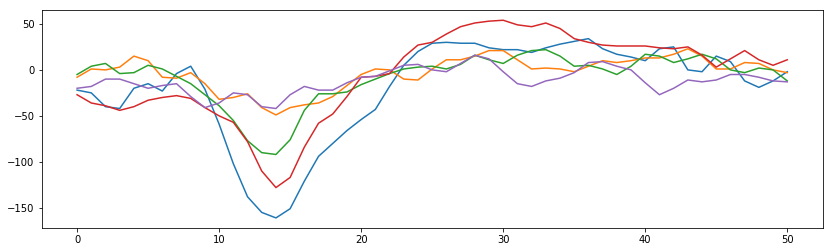

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [14, 18, 77, 90, 156]:
    plt.plot(H.spikes['Shape'][i])
plt.show()
    

In [10]:
length = H.spikes['Shape'][0].shape[0]
np.random.seed(5132)
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(48009, 51)


In [11]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data

torch.cuda.set_device(0)

In [12]:
class autoencoder(nn.Module):
    def __init__(self, input_size):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_size, 1024),
                                     nn.ELU(),
                                     nn.Linear(1024, 512),
                                     nn.ELU(),
                                     nn.Linear(512, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 128),
                                     nn.ELU(),
                                     nn.Linear(128, 64),
                                     nn.ELU(),
                                     nn.Linear(64, 32),
                                     nn.ELU(),
                                     nn.Linear(32, 16),)
        self.decoder = nn.Sequential(nn.Linear(16, 32),
                                     nn.ELU(),
                                     nn.Linear(32, 64),
                                     nn.ELU(),
                                     nn.Linear(64, 128),
                                     nn.ELU(),
                                     nn.Linear(128, 256),
                                     nn.ELU(),
                                     nn.Linear(256, 512),
                                     nn.ELU(),
                                     nn.Linear(512, 1024),
                                     nn.ELU(),
                                     nn.Linear(1024, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec
    
    def forward_numpy(self, x):
        #x = torch.from_numpy(x).float().cuda()
        enc, dec = self.forward(x)
        return dec

In [17]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print(electrode_data_test.shape)
print(electrode_data_train.shape)

(9602, 51)
(38407, 51)


In [14]:
import random

def train(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            out = model.forward_numpy(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print('epoch [{}/{}], loss:{:.7f}'.format(num_epoch + 1, epoch_range, loss.data[0]))
    return out

In [15]:
epoch_range = 50
batch_size = 250
learning_rate = 0.0001

model = autoencoder(length).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=0.001)

out = train(model, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/50], loss:627.5429077
epoch [2/50], loss:72.8137970
epoch [3/50], loss:189.9529266
epoch [4/50], loss:252.2511444
epoch [5/50], loss:69.4736252
epoch [6/50], loss:432.3219604
epoch [7/50], loss:153.9691772
epoch [8/50], loss:199.9762573
epoch [9/50], loss:235.6662903
epoch [10/50], loss:87.3691025
epoch [11/50], loss:86.0328293
epoch [12/50], loss:63.0484543
epoch [13/50], loss:80.0028915
epoch [14/50], loss:60.8387299
epoch [15/50], loss:163.1709595
epoch [16/50], loss:144.2817841
epoch [17/50], loss:67.6260986
epoch [18/50], loss:166.2120056
epoch [19/50], loss:56.0444717
epoch [20/50], loss:65.4742050
epoch [21/50], loss:125.0399780
epoch [22/50], loss:60.3321381
epoch [23/50], loss:158.5796051
epoch [24/50], loss:120.1791534
epoch [25/50], loss:105.3092804
epoch [26/50], loss:162.0202179
epoch [27/50], loss:63.4688416
epoch [28/50], loss:111.7425537
epoch [29/50], loss:41.0393105
epoch [30/50], loss:83.2014847
epoch [31/50], loss:98.1413727
epoch [32/50], loss:88.2236023
e

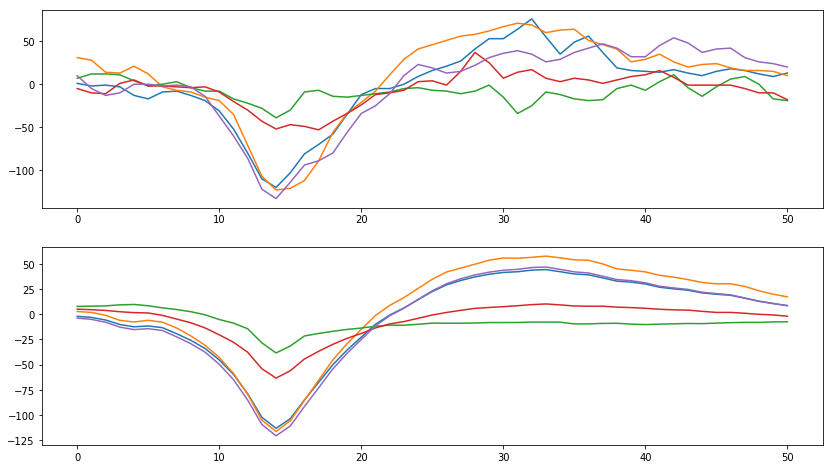

In [18]:
plt.figure(figsize=(14,8))

# n = [1, 30, 45, 50, 65]
n = [3400, 4598, 877, 6709, 8711]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    o = model.forward_numpy(data).cuda()
    o = (o.data).cpu().numpy()
    plt.subplot(211)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(212)
    plt.plot(o)
plt.show()